# Physics-Informed Neural Networks (PINNs) in Neuromancer

This tutorial demonstrates the use of [PINNs](https://en.wikipedia.org/wiki/Physics-informed_neural_networks) for solution and parameter estimation ([inverse problem](https://en.wikipedia.org/wiki/Inverse_problem)) of partial differential equations (PDEs) in the Neuromancer library.

<img src="../figs/PINNs.png" width="600">  

### References

[1] [Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations.](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125)

[2] https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets/tree/main

[3] https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main


## Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install neuromancer
!pip install pyDOE

*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

## Imports

In [1]:
# torch and numpy imports
import torch
import torch.nn as nn                    
import numpy as np

# data imports
from scipy.io import loadmat

# plotting imports
import matplotlib.pyplot as plt

# filter some user warnings from torch broadcast
import warnings
warnings.filterwarnings("ignore")


In [2]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


## Problem Setup

**[Burgers' Equation](https://en.wikipedia.org/wiki/Burgers%27_equation)** is convection–diffusion equation occurring in various areas of applied mathematics, such as fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. The equation is given as:

$$\frac{\partial y}{\partial t}+ \lambda y\frac{\partial y}{\partial x}=\nu\frac{\partial^2 y}{\partial x^2} $$

$$x\in[-1,1]$$
$$t\in[0,1]$$

Where $(x, t)$ represent spatio-temporal coordinates, $y(x, t)$ is the speed of the fluid at these corrdinates, and $\nu$ represents the unknown diffusion coefficient (or kinematic viscosity in the fluid mechanical context), and $\lambda$ is a second unknown parameter.

**Initial Condition:**

$$y(x,0)= -sin(\pi x)$$

**Boundary Conditions:**

$$y(−1, t) = 0$$
$$y(1, t) = 0$$

**Ground Truth Problem Parameters:**

$$\nu = 0.01/\pi$$
$$\lambda = 1.0$$


### Generate data of the exact solution

In [3]:
# Download the data if running on Colab
# local_path = "/content/data/burgers_shock.mat"
# url = "https://github.com/pnnl/neuromancer/raw/master/examples/PDEs/data/burgers_shock.mat"
# !mkdir -p /content/data
# !wget -O {local_path} {url}

data = loadmat('./data/burgers_shock.mat') 
x = data['x']                                   # space:      256 points between -1 and 1 [256x1]
t = data['t']                                   # time:       100 time points between 0 and 1 [100x1] 
ysol = data['usol']                             # velocitu:   PDE solution [256x100] 

X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
X = torch.tensor(X.T).float()
T = torch.tensor(T.T).float()
y_real = torch.tensor(ysol).float()

In [4]:
print(X.shape, T.shape, y_real.shape)

torch.Size([256, 100]) torch.Size([256, 100]) torch.Size([256, 100])


### Plot the solution

In [5]:
def plot3D(X, T, y):
    X = X.detach().numpy()
    T = T.detach().numpy()
    y = y.detach().numpy()

    #     2D
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    cm = ax1.contourf(T, X, y, 20,cmap="viridis")
    fig.colorbar(cm, ax=ax1) # Add a colorbar to a plot
    ax1.set_title('u(x,t)')
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_aspect('equal')
        #     3D
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(T, X, y,cmap="viridis")
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.set_zlabel('u(x,t)')
    fig.tight_layout()

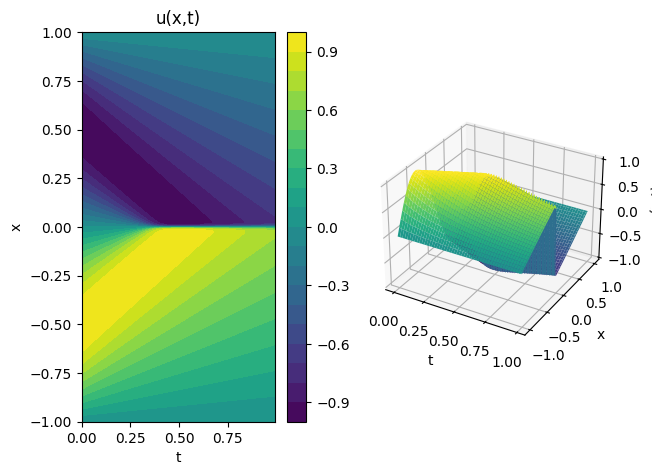

In [6]:
plot3D(X, T, y_real) 

### Test data: PDE solution

In [7]:
X_test = X.reshape(-1,1)
T_test = T.reshape(-1,1)
Y_test = y_real.reshape(-1,1) 

##  Construct training datasets

We construct training and development datasets given the PDE measurements $y(x,t)$ sampled over the spatio-temporal domain $(x,t)$.

The dataset is given as:
$\Xi_{\text{train/dev}} = [x^i, t^j, y^j]$, $i = 1,...,N_f$, 
Where $N_f$ defines number of training samples.

In [8]:
total_points=len(x)*len(t)

Nf = 1000  # Nf: Number of collocation points 

# Obtain random points of our PDE measurements y(x,t)
id_f = np.random.choice(total_points, Nf, replace=False)# Randomly chosen points for Interior
X_train_Nu = X_test[id_f]
T_train_Nu = T_test[id_f]
Y_train_Nu = Y_test[id_f]

In [9]:
print("We have",total_points,"points. We will select",X_train_Nu.shape[0],"points to train our model.")

We have 25600 points. We will select 1000 points to train our model.


### Plot PDE measurement points

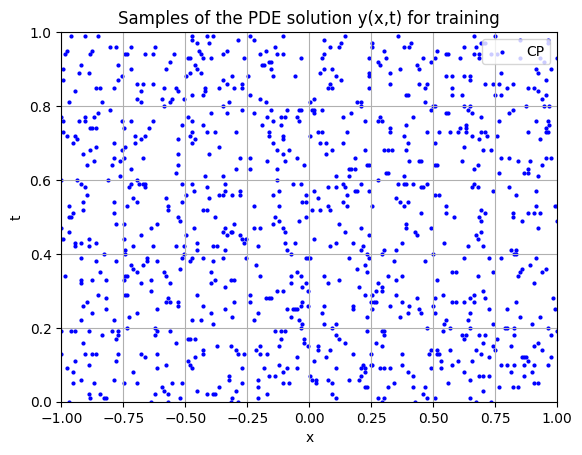

In [10]:
# visualize collocation points for 2D input space (x, t)
plt.figure()
plt.scatter(X_train_Nu.detach().numpy(), T_train_Nu.detach().numpy(),
            s=4., c='blue', marker='o', label='CP')
plt.title('Samples of the PDE solution y(x,t) for training')
plt.xlim(-1., 1.)
plt.ylim(0., 1.)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('t')
plt.legend(loc='upper right')
plt.show()
plt.show(block=True)

### Create Neuromancer datasets

In [11]:
from neuromancer.dataset import DictDataset

# turn on gradients for PINN
X_train_Nu.requires_grad=True
T_train_Nu.requires_grad=True

# Training dataset
train_data = DictDataset({'x': X_train_Nu, 't':T_train_Nu, 'y':Y_train_Nu}, name='train')
# test dataset
test_data = DictDataset({'x': X_test, 't':T_test, 'y':Y_test}, name='test')

# torch dataloaders
batch_size = X_train_Nu.shape[0]  # full batch training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         collate_fn=test_data.collate_fn,
                                         shuffle=False)

## PINN Architecture in Neuromancer

### Neural Network Architecture

We will use a neural network to approximate the PDE solution:
$$\hat{y} = NN_{\theta}(x,t)$$  

In [12]:
from neuromancer.modules import blocks
from neuromancer.system import Node

# neural net to solve the PDE problem bounded in the PDE domain 
net = blocks.MLP(insize=2, outsize=1, hsizes=[32, 32], nonlin=nn.Tanh)

# symbolic wrapper of the neural net
pde_net = Node(net, ['x', 't'], ['y_hat'], name='net')

In [13]:
print("symbolic inputs  of the pde_net:", pde_net.input_keys)
print("symbolic outputs of the pde_net:", pde_net.output_keys)

symbolic inputs  of the pde_net: ['x', 't']
symbolic outputs of the pde_net: ['y_hat']


In [14]:
# evaluate forward pass on the train data
net_out = pde_net(train_data.datadict)
net_out['y_hat'].shape

torch.Size([1000, 1])

###  Define Physics-informed terms 

Our neural network approximation  must satisfy the PDE equations  $NN_{\theta}(x,t) \approx y(x,t)$. 
Thus we define the physics-informed layers as $f_{\texttt{PINN}}$:

$$f_{\texttt{PINN}}(t,x)=
\frac{\partial NN_{\theta}(x,t)}{\partial t}+ \lambda NN_{\theta}(x,t) \frac{\partial NN_{\theta}(x,t)}{\partial x} -\nu\frac{\partial^2 NN_{\theta}(x,t)}{\partial x^2}
 $$

We can obtain the derivatives of the neural net $\frac{\partial NN_{\theta}}{\partial t},\frac{\partial^2 NN_{\theta}}{\partial x^2}$ using [Automatic Diferentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). 

In the inverse problem, we will jointly learn the neural network parameters $\theta$ together with unknown PDE parameters $\lambda$, and $\nu$.

To simplify the implementation of $f_{\texttt{PINN}}$ we exploit the symbolic variable of the Neuromancer library. 

In [15]:
from neuromancer.constraint import variable

# symbolic Neuromancer variables
y = variable('y')           # PDE measurements from the dataset
y_hat = variable('y_hat')  # PDE solution generated as the output of a neural net (pde_net)
t = variable('t')          # temporal domain
x = variable('x')          # spatial domain
# trainable parameters with initial values
lamb = variable(torch.nn.Parameter(torch.tensor(2.0)), display_name='lambda')       # trainable PDE parameter lambda
nu = variable(torch.nn.Parameter(torch.tensor(0.01)), display_name='nu')             # trainable PDE parameter nu

In [16]:
# get the symbolic derivatives
dy_dt = y_hat.grad(t)
dy_dx = y_hat.grad(x)
d2y_d2x = dy_dx.grad(x)
# get the PINN form
f_pinn = dy_dt + lamb*y_hat*dy_dx - nu*d2y_d2x

In [17]:
# check the shapes of the forward pass of the symbolic PINN terms
print(dy_dt({**net_out, **train_data.datadict}).shape)
print(dy_dx({**net_out, **train_data.datadict}).shape)
print(d2y_d2x({**net_out, **train_data.datadict}).shape)
print(f_pinn({**net_out, **train_data.datadict}).shape)

torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])


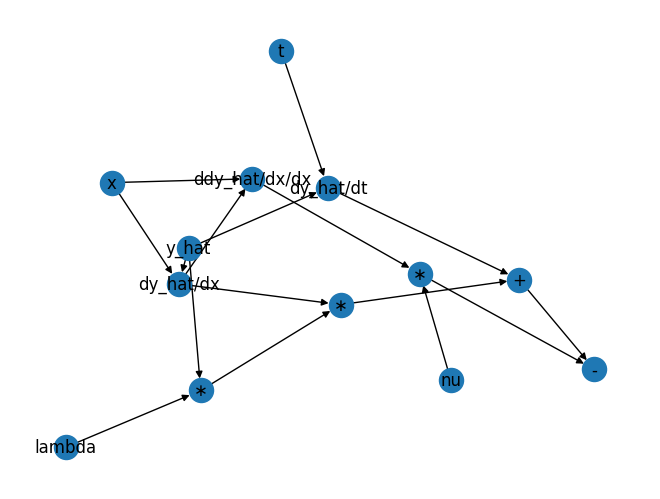

In [18]:
# computational graph of the PINN neural network
f_pinn.show()

### PINNs' Loss function terms

**PDE Collocation Points Loss:**  
We evaluate our PINN $f_{\texttt{PINN}}$ over given number ($N_f$) of collocation points (CP) and minimize the PDE residuals in the following loss function:

$$\ell_{1}=\frac{1}{N_f}\sum^{N_f}_{i=1}|f_{\texttt{PINN}}(t^i,x^i)|^2$$


If $f_{\texttt{PINN}}\rightarrow 0$ then our PINN will be respecting the physical law.

**PDE Measurements Loss:**

We select $N_f$ PDE measurement points $y(x,t)$ and minimize the supervised learning residual in the loss function:

$$\ell_{2}=\frac{1}{N_f}\sum^{N_f}_{i=1}|y(t^i,x^i)-NN_{\theta}(t^i,x^i)|^2$$

**Bound the PINN output in the PDE solution domain:**  
We expect the outputs of the neural net to be bounded in the PDE solution domain $NN_{\theta}(x,t) \in [-1.0, 1.0]$, thus we impose the following inequality constraints via additional penalties:

$$\ell_{3}=\frac{1}{N_f}\sum^{N_f}_{i=1} \Big(|\texttt{RELU}(NN_{\theta}(t^i,x^i) - y_{max})|^2 + |\texttt{RELU}(-NN_{\theta}(t^i,x^i) + y_{min})|^2 \Big)$$


#### Total Loss:
The total loss is just a sum of PDE residuals over CP and supervised learning residuals over IC and BC.
$$\ell_{\text{PINN}}=\ell_{1}+\ell_{2} +\ell_{3}$$

In [19]:
# scaling factor for better convergence
scaling = 1000.

# PDE CP loss
ell_1 = (f_pinn == 0.)^2

# PDE supervised learning loss
ell_2 = scaling*(y_hat == y)^2 

# ell_3 = output constraints to bound the PINN solution in the PDE output domain [-1.0, 1.0]
con_1 = (y_hat <= 1.0)^2
con_2 = (y_hat >= -1.0)^2

##  Train the PINN to solve the PDE

We use stochastic gradient descent to optimize the parameters $\theta$ of the neural network $NN_{\theta}(t,x)$ approximating the solution to the PDE equation $y(t,x)$ using the PINN loss $\ell_{\text{PINN}}$ evaluated over sampled CP, IP, and BC.

### Define the optimization problem in Neuromancer

In [20]:
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem

# create Neuromancer optimization loss
pinn_loss = PenaltyLoss(objectives=[ell_1, ell_2], constraints=[con_1, con_2])

# construct the PINN optimization problem
problem = Problem(nodes=[pde_net],      # list of nodes (neural nets) to be optimized
                  loss=pinn_loss,       # physics-informed loss function
                  grad_inference=True   # argument for allowing computation of gradients at the inference time)
                 )

### Construct Trainer and solve the problem  

In [21]:
from neuromancer.trainer import Trainer

optimizer = torch.optim.AdamW(problem.parameters(), lr=0.001)
epochs = 10000

#  Neuromancer trainer
trainer = Trainer(
    problem.to(device),
    train_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=200,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs,
    device=device
)

In [22]:
# Train PINN
best_model = trainer.train()

# load best trained model
problem.load_state_dict(best_model)

epoch: 0  train_loss: 370.78009033203125
epoch: 200  train_loss: 83.9358139038086
epoch: 400  train_loss: 26.59113883972168
epoch: 600  train_loss: 16.921268463134766
epoch: 800  train_loss: 10.921873092651367
epoch: 1000  train_loss: 8.0209379196167
epoch: 1200  train_loss: 6.5286102294921875
epoch: 1400  train_loss: 5.424567699432373
epoch: 1600  train_loss: 4.550571441650391
epoch: 1800  train_loss: 3.8836967945098877
epoch: 2000  train_loss: 3.374181032180786
epoch: 2200  train_loss: 2.9693143367767334
epoch: 2400  train_loss: 2.635749578475952
epoch: 2600  train_loss: 2.344210147857666
epoch: 2800  train_loss: 2.083545446395874
epoch: 3000  train_loss: 1.8520342111587524
epoch: 3200  train_loss: 1.6507803201675415
epoch: 3400  train_loss: 1.486864686012268
epoch: 3600  train_loss: 1.3457746505737305
epoch: 3800  train_loss: 1.2182989120483398
epoch: 4000  train_loss: 1.1023818254470825
epoch: 4200  train_loss: 1.0011675357818604
epoch: 4400  train_loss: 0.9131717681884766
epoch: 4

<All keys matched successfully>

## Results

### Parameter estimation results

Remember our ground truth parameters we want to estimate are: $\nu = 0.01/\pi$, and $\lambda = 1.0$.

In [23]:
print('True parameter lambda = ', 1.0)
print('Estimated parameter lambda = ', float(lamb.value))
print('True parameter nu = ', 0.01/np.pi)
print('Estimated parameter nu = ', float(nu.value))

True parameter lambda =  1.0
Estimated parameter lambda =  0.9352328777313232
True parameter nu =  0.003183098861837907
Estimated parameter nu =  0.0038641004357486963


In [24]:
# evaluate trained PINN on test data
PINN = problem.nodes[0].cpu()
y1 = PINN(test_data.datadict)['y_hat']

# arrange data for plotting
y_pinn = y1.reshape(shape=[256,100]).detach().cpu()

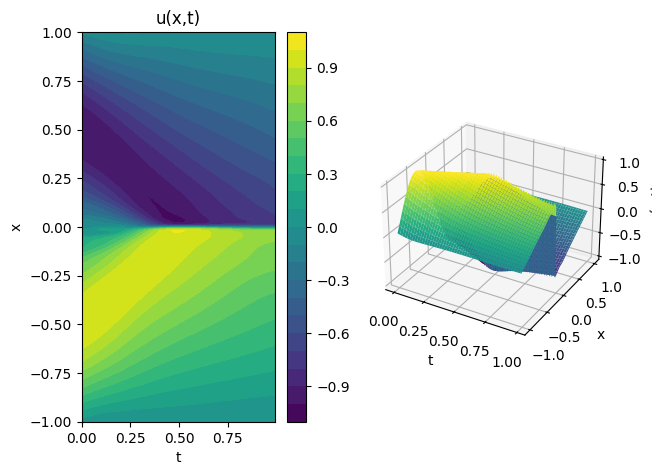

In [25]:
# plot PINN solution
plot3D(X, T, y_pinn)

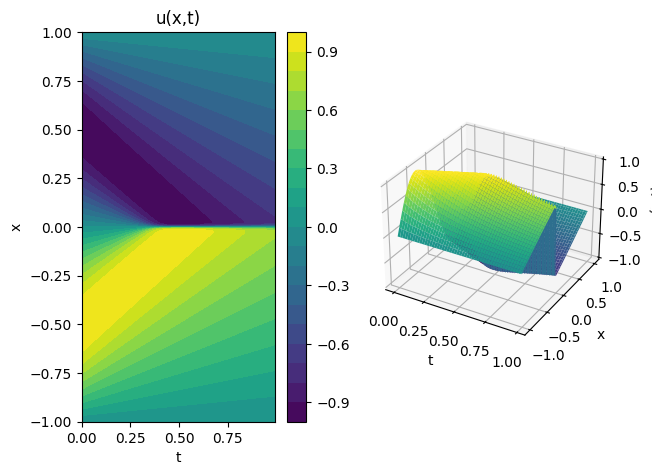

In [26]:
# plot exact PDE solution
plot3D(X, T, y_real)

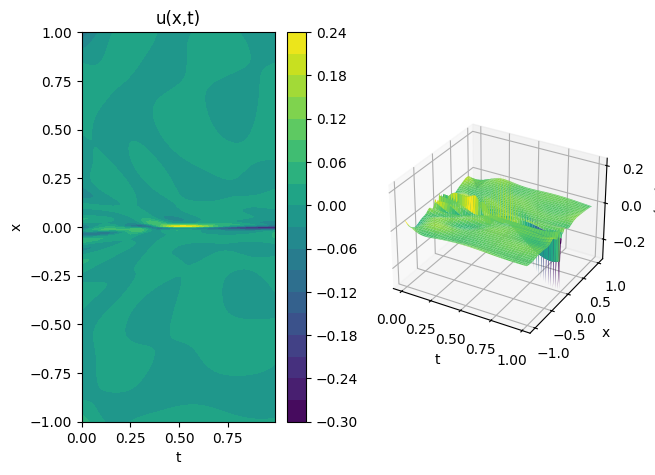

In [27]:
# plot residuals PINN - exact PDE
plot3D(X, T, y_pinn-y_real)